# Ring Background Example

Files for this analysis can be downloaded from [here](https://drive.proton.me/urls/JSGH2TARWW#sgLZ8E2GvsBZ) using the standard VERITAS password.


In this example we'll use the ring background method to obtain the significance of a source in a crowded FoV. 

We'll be analyzing data on LS 5039,  a point source which has the extended source HESS J1825-137 within the FoV.

WE'll perform the following steps:
1. [Define our analysis using a config](#config)
2. [Extract the data into a dataset](#extraction)
3. [Define an exclusion mask for determining the background](#exclusion)
4. [Perform a ring background estimation of the background](#background)
5. [Generate 2D significance maps and estimate the significance of LS 5039](#skymaps)

In [1]:
import logging
import numpy as np
from scipy.stats import norm

# %matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import RingBackgroundMaker
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator
from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel, SkyModel
from gammapy.estimators.utils import find_peaks
from astroquery.simbad import Simbad
log = logging.getLogger(__name__)

# Defining a config
<a id='config'></a>

Using an `AnalysisConfig` we ca  define various parameters for the analysis. Here are some of the important one:
* `config.observations.obs_cone` This is the cone in the sky for which we search for observations. We are defining a region of 3.5 degrees centred on the source location. Falling within this cone will be included
* `config.datasets.geom.wcs` This is our "world coordinate system (WCS)". This defines the scales used when creating sky maps. Here we define the WCS to be centred on the source position. We make it large enough, giving it a widght and height of 5 degrees and set the binning of the wcs to 0.02 degrees.
* `config.datasets.geom.selection.offset_max` This select the maximum offset a run can have when being included in the analysis. 
* `config.datasets.safe_mask.parameters` This sets some parameters of "safe" analysis ranges. Here we'll define the energy range threshold at 15% of the maximum effective area. We'll also set the maximum offset and event can have to be 1.5 degrees
* `config.datasets.safe_mask.methods` This is setting the methods we're using to define our safe analysis regieme.
* `config.datasets.geom.axes.energy` This sets the energy axes for the analysis.

In [2]:
source_pos = SkyCoord.from_name("LS 5039")

config = AnalysisConfig()
# Select observations - 2.5 degrees from the source position
config.observations.datastore = "./moderate2tel/"
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": 3.5 * u.deg,
}

config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  
# The WCS geometry - centered on MSH 15-52
config.datasets.geom.wcs.width = {"width": "5.0 deg", "height": "5.0 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.parameters = {"aeff_percent":0.15, "offset_max" : 1.5*u.deg}
config.datasets.safe_mask.methods = ["aeff-max", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "100 TeV"
config.datasets.geom.axes.energy.nbins = 20

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False

print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: moderate2tel
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 276.56273398 deg, lat: -14.84840202 deg, radius: 3.5
                deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir: {frame: icrs, lon: 276.56273398 deg, lat: -14.84840202 deg}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 100.0 TeV, nbins: 20}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
     

# Extracting Data
<a id='extraction'></a>

Using the config we just defined, we'll search observations matching our criteria. We'll also start the process of extracting the data. This can take a while for longer run lists

In [3]:
analysis = Analysis(config)

# for this specific case, we do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

# `First get the required observations
analysis.get_observations()


Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 17 out of 17.
Number of selected observations: 17


In [4]:
analysis.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 69054
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 69123
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 69187
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 69188
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 69202
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 69203
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 73193
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 73213
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 73234
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 73300
Running MapDatasetMaker
Running SafeMas

# Creating an exclusion mask
<a id='exclusion'></a>

We defind the exclusion mask. This defines regions of the sky to ignore when determining the background. When using a ring background (RBM), a reflected region or a template FoV background estimation, the area of the sky included in the exclusion mask will be excluded from the background estimation.

In the case of RBM, the exclusion regions are excluded from the local background renormalization.

If you have network access you can use Astropy/Astroquery to determine locations of known sources and bright stars. Below is an example of quering Simbad for bright stars in the FoV. 

In [5]:
# simbad = Simbad()
# simbad.reset_votable_fields()
# simbad.add_votable_fields('ra', 'dec', "flux(B)", "flux(V)", "jp11")
# simbad.remove_votable_fields('coordinates')

# srcs_tab = simbad.query_region(source_pos, radius=2*u.deg)
# srcs_tab = srcs_tab[srcs_tab["FLUX_B"]<8]
# srcs_tab = srcs_tab[srcs_tab["FLUX_V"]!=np.ma.masked]
# srcs_tab

We'll create an exclusion mask which contains the source of interest (LS 5039) and the extended source in the FoV (HESS J1825-137).

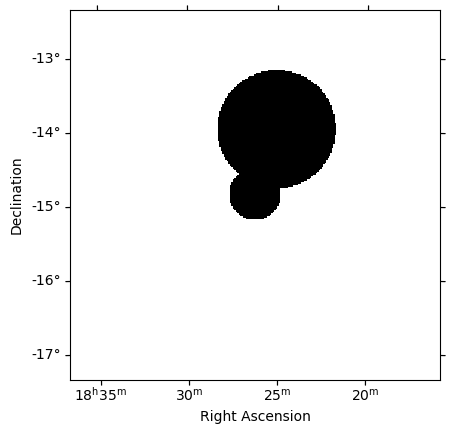

In [6]:
# get the geom that we use
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=source_pos, radius=0.35 * u.deg)
region_hess = CircleSkyRegion(center=SkyCoord(276.26  * u.deg, -13.97* u.deg, frame = "fk5"), radius=0.8 * u.deg)

all_ex = [regions, region_hess]
# stars = []
# for star in srcs_tab:
#     pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
#     star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
#     stars.append(star)
#     all_ex.append(star)

exclusion_mask = ~geom_image.region_mask(all_ex)
exclusion_mask.sum_over_axes().plot()


source_only_mask = ~geom_image.region_mask([regions])
exclusion_mask.write("exclusion_mask.fits", overwrite="True")

plt.show()

It's useful to save the exclusion mask, we'll use it later in different examples.

# Run Ring Background Analysis
<a id='background'></a>

We'll use the `RingBackgroundMaker` to perform the ring background estimation. We pass the arguments `r_in` which is the inner radius of the RBM, `width` which is the width of the ring (`r_out` = `r_in` + `width`) and the `exclusion_mask` we have just generated.

In [7]:
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

A `MapDatasetOnOff` is used for our dataset. We'll flatten the 3D images (x,y, energy) to 2D images (x,y) for the RBM analysis.

In [8]:
energy_axis_true = analysis.datasets[0].exposure.geom.axes["energy_true"]
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)

for dataset in analysis.datasets:
    # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

In [9]:
print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : stacked 

  Total counts                    : 16815 
  Total background counts         : 15184.23
  Total excess counts             : 1630.77

  Predicted counts                : 15186.69
  Predicted background counts     : 15186.69
  Predicted excess counts         : nan

  Exposure min                    : 8.48e+01 m2 s
  Exposure max                    : 7.95e+09 m2 s

  Number of total bins            : 62500 
  Number of fit bins              : 29446 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 27424.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 23001856 
  Acceptance                      : 62500 
  Acceptance off                  : 100823016 



# Generate Sky Maps
<a id='skymaps'></a>

We'll use the `ExcessMapEstimator` to determine the signifiance at each point in the sky. This requires a convolution radius, this will convolve events with a 0.089 degree radius top hat function to find the significance at that bin. This is analogous to a $\theta$ cut of 0.089 degrees. 

The significance is estimated as the $\sqrt{TS}$ when comparing to the null hypothesis (a flat background). For a gamma-quiet region we'd assume $\sqrt{TS}\approx\mathcal{N}(0,1)$.

/opt/conda/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


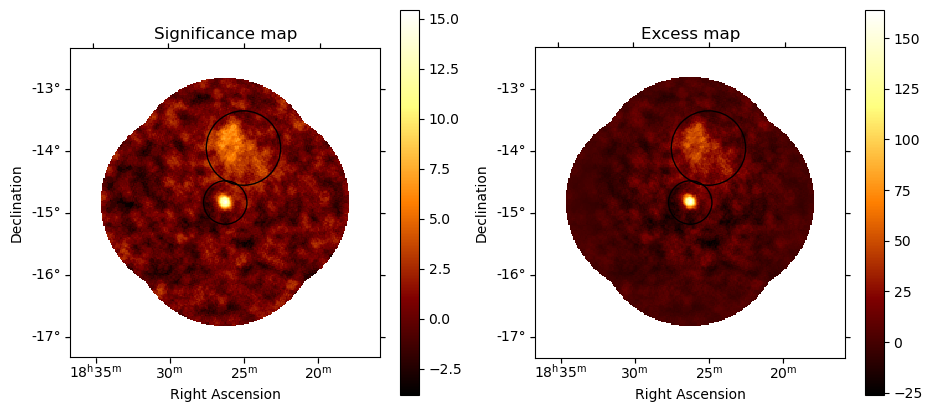

In [10]:
# Using a convolution radius of 0.089 degrees
estimator = ExcessMapEstimator( 0.089 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked_on_off)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

# for star in srcs_tab:
    
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)


for ax in [ax1,ax2]:
    region = CircleSkyRegion(source_pos, radius=0.35 * u.deg)
    region.to_pixel(wcs = lima_maps.geom.wcs).plot(ax=ax)


    region = CircleSkyRegion(region_hess.center, radius=0.6 * u.deg)
    region.to_pixel(wcs = lima_maps.geom.wcs).plot(ax=ax)

fig.savefig("LS5039Maps.png")
plt.show()

A significance distribution can be obtained by binning the contents of the $\sqrt{TS}$ map. Using the exclusion regions we previously define, we can extract the distributions excluding various regions of the map.

* Red: all bins
* Gray: excluding LS 5039
* Blue: excluding LS 5039, HESS J1825-137 and any stars

To test if the background is well behaved, we can fit the blue distribution with a Gaussian. For a well-behaved fit we expect $\mu = 0$, $\sigma = 1$.

Fit results: mu = 0.05, std = 1.03


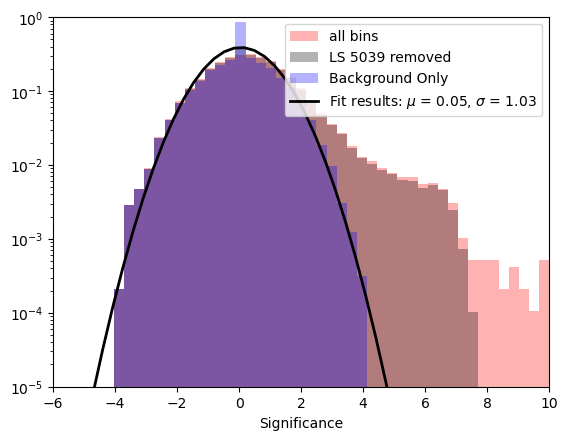

In [11]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_map_source_only = significance_map * source_only_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[np.isfinite(significance_map_off.data)]
significance_source = significance_map_source_only.data[np.isfinite(significance_map_source_only.data)]

fig, ax = plt.subplots()
ax.hist(
    significance_all,
    density=True,
    alpha=0.3,
    color="red",
    label="all bins",
    bins=np.linspace(-6,10),
)

ax.hist(
    significance_source,
    density=True,
    alpha=0.3,
    color="black",
    label="LS 5039 removed",
    bins=np.linspace(-6,10),
)

ax.hist(
    significance_off,
    density=True,
    alpha=0.3,
    color="blue",
    label="Background Only",
    bins=np.linspace(-6,10),
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black", label=f"Fit results: $\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax.set_xlim(-6, 10)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
# ax.text(-2, 0.001, f"Fit results: $\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
# ax.grid(which = "both")
plt.savefig("LS5039RBM.png")
plt.show()



The background looks well behaved. We can estimate the significance of LS 5039 using the generated maps. To do so we pass the source position. Note that the `get_by_coord` assumes a 3D map (x,y,enegy). Since we have flattened the map to 2D we only have 1 energy bin. We can use any energy within our previously definded range.

In [12]:
ls_5039_sigma = significance_map.get_by_coord([source_pos.ra, source_pos.dec, 1 * u.TeV])[0]
print(f"Detection Significance: {ls_5039_sigma:0.2f}")


Detection Significance: 14.12


## Extended source analysis

We can run an extended analysis by using a larger covolution radius. For a full 3D analysis of extended sources see the [3D Analysis notebook](3DAnalysis.ipynb).

/opt/conda/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


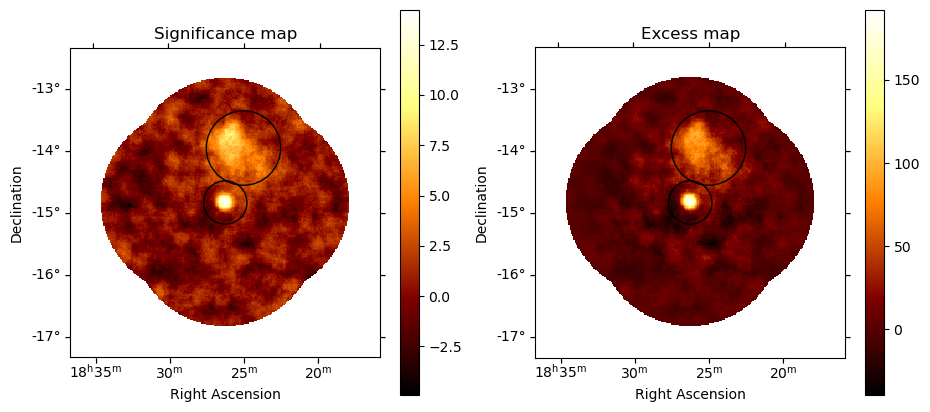

In [13]:
# Using a convolution radius of 0.12 degrees
estimator = ExcessMapEstimator( 0.12 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked_on_off)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)



# for star in srcs_tab:
    
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

for ax in [ax1,ax2]:
    region = CircleSkyRegion(source_pos, radius=0.35 * u.deg)
    region.to_pixel(wcs = lima_maps.geom.wcs).plot(ax=ax)


    region = CircleSkyRegion(region_hess.center, radius=0.6 * u.deg)
    region.to_pixel(wcs = lima_maps.geom.wcs).plot(ax=ax)


    
fig.savefig("LS5039Maps_extended.png")
plt.show()

Fit results: mu = 0.08, std = 1.09


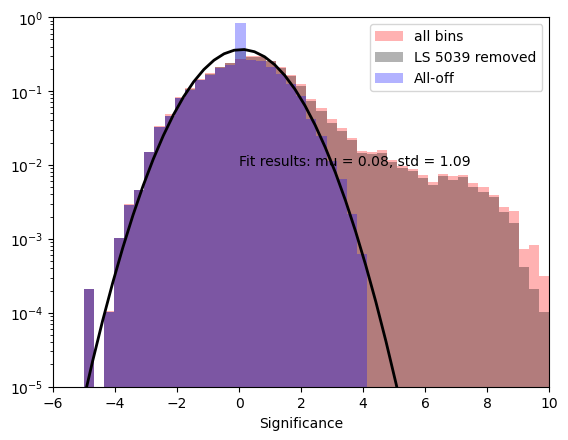

In [14]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_map_source_only = significance_map * source_only_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[np.isfinite(significance_map_off.data)]
significance_source = significance_map_source_only.data[np.isfinite(significance_map_source_only.data)]

fig, ax = plt.subplots()
ax.hist(
    significance_all,
    density=True,
    alpha=0.3,
    color="red",
    label="all bins",
    bins=np.linspace(-6,10),
)

ax.hist(
    significance_source,
    density=True,
    alpha=0.3,
    color="black",
    label="LS 5039 removed",
    bins=np.linspace(-6,10),
)

ax.hist(
    significance_off,
    density=True,
    alpha=0.3,
    color="blue",
    label="All-off",
    bins=np.linspace(-6,10),
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black")
ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax.set_xlim(-6, 10)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
ax.text(0, 0.01, f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
# ax.grid(which = "both")
plt.savefig("LS5039RBM_extended.png")
plt.show()